# Study of Finch beak in island Daphne Major

The island of Daphne Major, has Finches of Geospiza fortis, Geospiza scandens

## Data Source:
* Peter and Rosemary Grant
    * 40 Years of Evolution: Darwin's Finches on Daphne Major island
    * Princeton University Press, 2014
* Data accquired from Dryad Digital Repository
    * https://doi.org/10.5061/dryad.g6g3h

## The dimension of the finch beak
* beak length in millimeters (mm)
* beak depth in millimeters (mm)

## Investigation of Geospiza scandens beak depth
* EDA of beak depths in 1975 and 2012
* Parameter estimation of mean beak depth
* Hypothesis test: did the beaks get deeper?

## Variation in beak shapes
* Is beak shape changing?

## Calculation of heritability
* Heredity - The tendency of parental traits to be inherited by offspring.

## Steps to Perform Analysis
* Perform EDA
    * Generate effective plots like ECDFs
    * Compute summary statistics
* Estimate parameters
    * By optimization, including linear regression
    * Determine confidence intervals
* Formulate and test hypothesis

## Import python packages / dependencies

In [280]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Extract, load and clean the data

In [281]:
# Extract and load data
# Fig. 10-03 data, 75.csv
finch_beaks_1975 = pd.read_csv(r'data/finch_beaks_1975.csv')

# Fig. 10-03 data, 12.csv
finch_beaks_2012 = pd.read_csv(r'data/finch_beaks_2012.csv')

# Fig. 03-03(fortis) Offspring bands = averages of offspring band 
#      numbers; femband = social mother; BD = beak depth 
fortis_beak_depth_heredity = pd.read_csv(r'data/fortis_beak_depth_heredity.csv')

scandens_beak_depth_heredity = pd.read_csv(r'data/scandens_beak_depth_heredity.csv')

In [282]:
# Display the data
display(finch_beaks_1975.head(2))
display(finch_beaks_2012.head(2))
display(fortis_beak_depth_heredity.head(2))
display(scandens_beak_depth_heredity.head(2))

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3


,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9


,Mid-offspr,Male BD,Female BD
0,10.70,10.9,9.3
1,9.78,10.7,8.4


,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468


In [283]:
# Clean the data

finch_beaks_1975['year'] = 1975
finch_beaks_1975.rename(columns = {'Beak length, mm':'beak_length', 'Beak depth, mm':'beak_depth'}, inplace=True)

finch_beaks_2012['year'] = 2012
finch_beaks_2012.rename(columns = {'blength':'beak_length', 'bdepth':'beak_depth'}, inplace=True)

## Investigation of Geospiza scandens beak depth

### EDA of beak depths of Darwin's finches

Study changes in beak geometry over time. Look at beak depth of G. scandens on Daphne Major in 1975 and in 2012.

* Plot beak depth measurement's in bee swarm plot
* Plot the ECDFs for the 1975 and 2012 beak depth measurements on the same plot.
* Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.
* Formulate hypothesis test

In [284]:
# Create dataframe with beak depth and year for 1975 and 2012
df = pd.concat([finch_beaks_1975, finch_beaks_2012], ignore_index=True)
df_scandens = df[df['species']=='scandens']

# Store beak depth for each year in numpy array
bd_1975 = np.array(df_scandens[df_scandens['year']==1975]['beak_depth'])
bd_2012 = np.array(df_scandens[df_scandens['year']==2012]['beak_depth'])

# Store beak length for each year in numpy array
bl_1975 = np.array(df_scandens[df_scandens['year']==1975]['beak_length'])
bl_2012 = np.array(df_scandens[df_scandens['year']==2012]['beak_length'])

In [285]:
bd_2012.shape

(127,)

### Plot Bee Swarm Plot

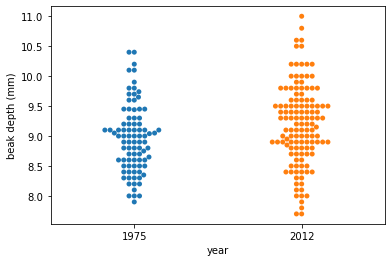

In [286]:
# Create bee swarm plot
_ = sns.swarmplot(x=df_scandens['year'], y=df_scandens['beak_depth'])

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

###### In the plot, difference between 1975 and 2012 is not very clear. It looks like mean of 2012 data set might be slightly higher, and it might have bigger variance.

### ECDFs of beak depths

In [287]:
# Function to compute ECDF

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    import numpy as np
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

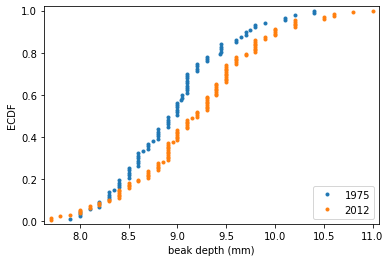

In [288]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

###### The difference is much clearer in ECDF. The mean is larger in 2012 data, and variance is also larger.

### Bootstraping of beak depths data

In [289]:
# Function to do bootstrapping

# Generate bootstrap replicate
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

# Generating many bootstrap replicates
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [290]:
# Parameter estimates of beak depths

# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05561313 0.38969529] mm


### Hypothesis test: Are beaks deeper in 2012?

Based on ECDF and confidence interval, it is clear that beak depths of G. Scandens have gotten deeper. Answer the following questions to justify the dataset:
* Is it possible that this effect is just due to random chance? 
* What is the probability that we would get the observed difference in mean beak depth if the means were the same?

Do a permutation test as data of beak depths did not come from same distribution.

##### The hypothesis is that the means are equal.

In [291]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p-value =', p)

p-value = 0.004


##### p-value is 0.0035, which suggests that there is statistically significant difference.

Conclusion: Difference of 0.2 mm between the means. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

## Variation in beak shapes of Geospiza scandens

### EDA of beak length and depth

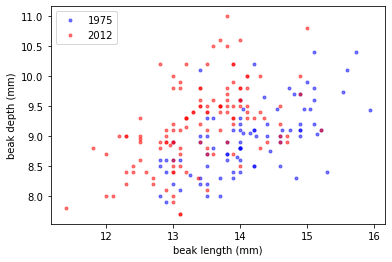

In [292]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

### Linear regressions
* Perform a linear regression for both the 1975 and 2012 data.
* Perform pairs bootstrap estimates for the regression parameters.
* Report 95% confidence intervals on the slope and intercept of the regression line.

In [293]:
# Function to do pairs bootstrap
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [294]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])


# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.46520516916059357 conf int = [0.33187833 0.59204182]
1975: intercept = 2.3908752365842285 conf int = [0.64261677 4.28874164]
2012: slope = 0.4626303588353127 conf int = [0.3428137  0.60265302]
2012: intercept = 2.9772474982360158 conf int = [1.1403339  4.57424999]


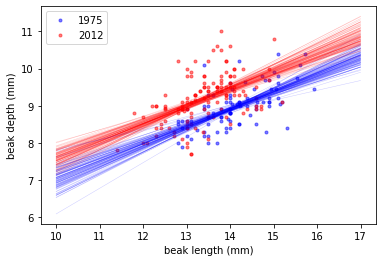

In [295]:
# Displaying the linear regression results

# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps_1975[i]*x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i]*x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

##### The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years.Compare the ratio of beak length to beak depth to see changes in shape of the beak.

In [296]:
# Beak length to depth ratio

# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55710344 1.60059865]
2012: mean ratio = 1.4658342276847767 conf int = [1.44461089 1.48842428]


###### How different is the ratio?

The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping, so this is a real change. The beak shape changed.

## Calculation of heritability
* EDA of parents and offsprings data - see correlation
* See correlation using Pearson Correlation Coefficient
* See correlation with 95% confidence interval
* Measure heritability with 95% confidence interval

## EDA of heritability

In [297]:
# Clean and prepare data

# G. Scandens average beak depths of parents and offsprings
bd_parent_scandens = np.array(scandens_beak_depth_heredity.mid_parent)
bd_offspring_scandens = np.array(scandens_beak_depth_heredity.mid_offspring)

# G. Fortis average beak depths of parents and offsprings
bd_parent_fortis = np.array((fortis_beak_depth_heredity['Male BD'] + fortis_beak_depth_heredity['Female BD']) / 2)
bd_offspring_fortis = np.array(fortis_beak_depth_heredity['Mid-offspr'])

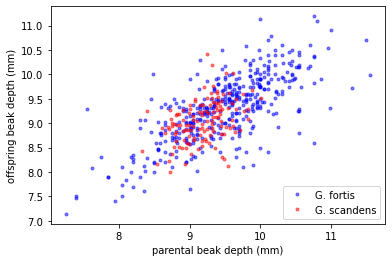

In [298]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
             
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()

It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis.

## Correlation of offspring and parental data

Compute statistics, such as the Pearson correlation coefficient, between parents and offspring.

In [299]:
# Function to perform pairs bootstrap and computes a single statistic on pairs samples defined
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

# Computing the Pearson correlation coefficient
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [300]:
# Pearson correlation of offspring and parental data

# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, \
                                    bd_offspring_scandens, pearson_r, 1000)

bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, \
                                    bd_offspring_fortis, pearson_r, 1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


G. scandens: 0.4117063629401259 [0.26583456 0.54261009]
G. fortis: 0.7283412395518485 [0.66970763 0.78049688]


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

## Measuring heritability

In [301]:
# Computes heritability defined as the ratio of the covariance of the trait in parents 
# and offspring divided by the variance of the trait in the parents. 

def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1]/ covariance_matrix[0,0]

In [302]:
# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, 1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, 1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685983 [0.35162683 0.74006068]
G. fortis: 0.7229051911438154 [0.65027228 0.8005523 ]


G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.

## Is beak depth heritable at all in G. scandens?

Hypothesis: Above observed heritability was just achieved by chance and beak depth is actually not really heritable in the species.

In [303]:
# Permutation test to check the hypothesis

# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0


p-value is zero, which means that none of the 10,000 permutation pairs replicates had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis.

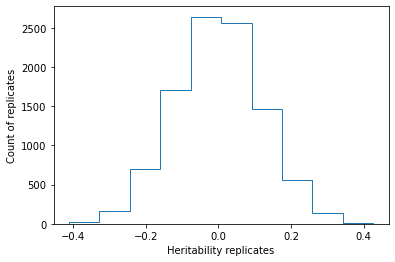

In [304]:
# Plot a histogram

_ = plt.hist(perm_replicates, histtype='step')
_ = plt.xlabel('Heritability replicates')
_ = plt.ylabel('Count of replicates')